In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Define dataset directory and image size
training_dir = '/content/training/'
image_size = (100, 100)
batch_size = 32

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,       # Random rotations
    width_shift_range=0.2,   # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,         # Shearing transformations
    zoom_range=0.2,          # Zoom transformations
    horizontal_flip=True,    # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],  # Adjust brightness
    channel_shift_range=0.2,  # Adjust color channels
    fill_mode='nearest',     # Fill missing pixels
    validation_split=0.2     # 80% training, 20% validation
)

# Only rescale for validation data (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training and validation datasets
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset="training",
    seed=42, shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset="validation",
    seed=42
)




Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

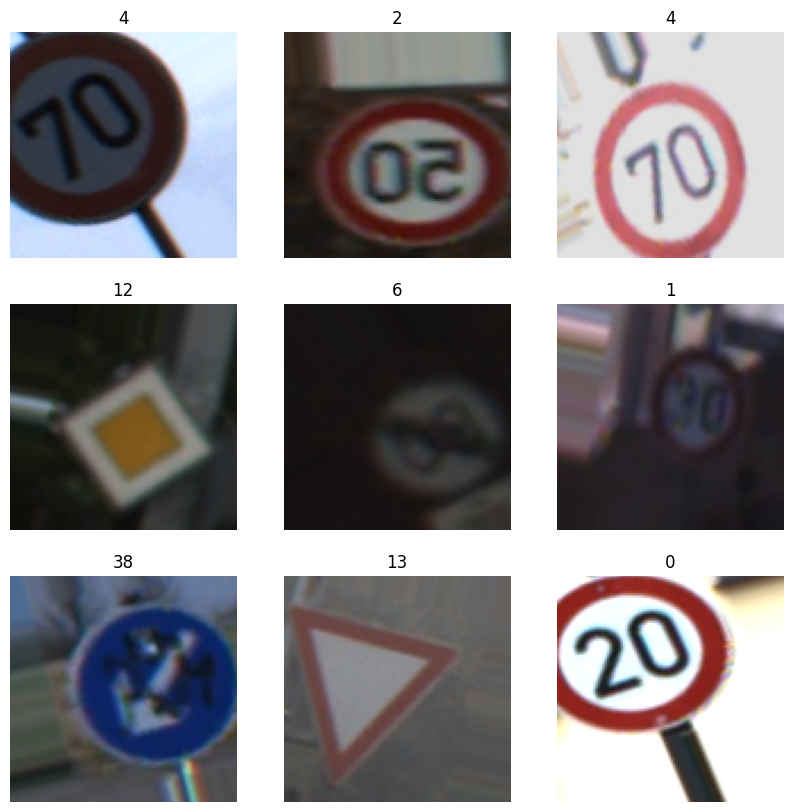

In [13]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:

model = keras.Sequential([
    layers.Conv2D(32, (4, 4), activation="relu", padding="same", input_shape=(100, 100, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (4, 4), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (4, 4), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (4, 4), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation= "relu"),
    layers.Dense(43, activation="softmax")
])

# Compile the model with an increased learning rate and the Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"]
)

# Define Early Stopping Callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Print model summary
model.summary()

# Train the model with increased epochs and data augmentation
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping],

)

# Evaluate the model on the validation dataset
from sklearn.metrics import accuracy_score, classification_report
# Predict on the entire validation dataset in one go
pred_probs = model.predict(validation_generator)

# Convert probabilities to predicted class indices
predicted_labels = np.argmax(pred_probs, axis=1)

# Get the true labels
true_labels = validation_generator.classes  # Directly access true labels

# Compute accuracy and classification report
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

#plot history

import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict["sparse_categorical_accuracy"], label="Train Accuracy")
plt.plot(history_dict["val_sparse_categorical_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict["loss"], label="Train Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()

plt.show()




Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 100, 100, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 50, 50, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 25, 25, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 12, 12, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,880,971 (7.18 MB)

 Trainable params: 1,880,971 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 128s 126ms/step - loss: 3.1232 - sparse_categorical_accuracy: 0.1462 - val_loss: 2.0382 - val_sparse_categorical_accuracy: 0.3516
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 122ms/step - loss: 1.6338 - sparse_categorical_accuracy: 0.4673 - val_loss: 1.5905 - val_sparse_categorical_accuracy: 0.4863
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 121ms/step - loss: 1.0584 - sparse_categorical_accuracy: 0.6437 - val_loss: 1.0730 - val_sparse_categorical_accuracy: 0.6743
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 121s 123ms/step - loss: 0.6234 - sparse_categorical_accuracy: 0.7883 - val_loss: 0.8944 - val_sparse_categorical_accuracy: 0.7508
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 120s 123ms/step - loss: 0.4247 - sparse_categorical_accuracy: 0.8551 - val_loss: 0.7523 - val_sparse_categorical_accuracy: 0.8064
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 120s 122ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.8944 - val_loss: 0.5299 - val_sparse_categoric

## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```